# CNN

Maybe we just showed that a neural net can optimize for two problems at once? Maybe we just got lucky. After all, our structure was a bit strange and non-intuitive. So, basically, the network was able to achieve the same performance as the standard, unaltered case, while associated layers with features. Yes, this is interpretability, but this might not be scalable to larger models.

We would hope that with the weaker loss from the side quests that the information is still throwing throw the network, s.t. the horizontal layer can be combined with the vertical layer in classification instead of mainly the vertical layer being the reason behind classification. So, we want both side quests to matter, instead of one side quest informing the next side quest, when then informs our final quest.

Again, the problem of sub-labeling data appears for constructing a neural net that uses each layers to build up patterns from the ground up.

Perhaps though we would be able to better do this in a CNN, apply loss to our weights or the final classificaiton layer.

Let's get crackin!

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

### Intermediate Data Labels

In [4]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

In [5]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

## CNN Architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,    # 1 channel for grayscale images
                  out_channels=2,                # 2 kernels/filters, so 2 output channels
                  kernel_size=3,                 # 3x3 convolutional kernel
                  stride=1,                      # move the kernel 1 pixel at a time
                  padding=1)                     # pad the input so the output size remains 28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # this will reduce the dimensions by a factor of 2
        self.fc1 = nn.Linear(14 * 14 * 2, 10)  # fully connected layer taking in the reduced images of 14x14 and outputing the 10 classes

        self.activation_function = nn.ReLU()

    def forward(self, x):
        # convolutional layer
        conv_out = self.conv1(x)
        conv_act = self.activation_function(conv_out)

        # pooling layer
        pool_out = self.pool(conv_act)
        fc1_in = pool_out.view(pool_out.size(0), -1)
        
        classification_out = self.fc1(fc1_in)
        
        return classification_out, pool_out, conv_act

In [7]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
model = CNN().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [9]:
print(f"Model weights (to compare below): {model.conv1.weight[0].detach().cpu().numpy()}")

Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]


What we should see from the above weight matrix output, to verify reproducibility:

```
Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]
```

## Dataloader

In [10]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).unsqueeze(0).float()
        
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)
        horizontal_edge = torch.from_numpy(self.horizontal_edges[idx].copy()).unsqueeze(0).float()
        vertical_edge = torch.from_numpy(self.vertical_edges[idx].copy()).unsqueeze(0).float()

        return image, label, horizontal_edge, vertical_edge

In [11]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [12]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

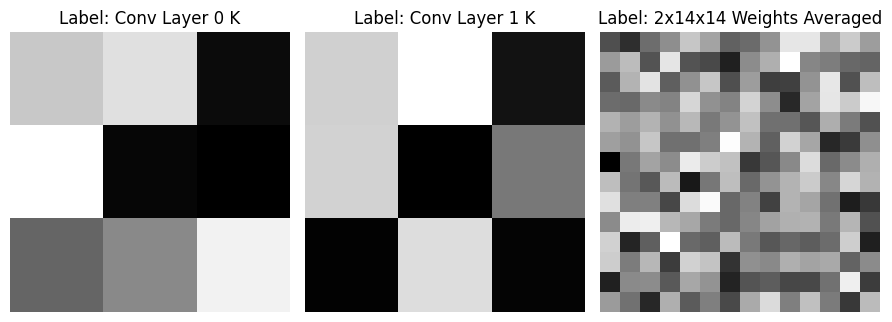

Epoch 1/20
  Train Loss: 2.3340
  Val Loss: 0.6464 | Val Acc: 86.81%


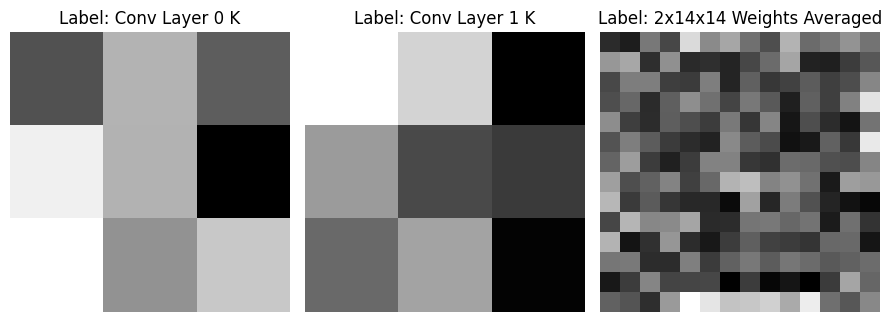

Epoch 2/20
  Train Loss: 0.4441
  Val Loss: 0.3902 | Val Acc: 88.89%


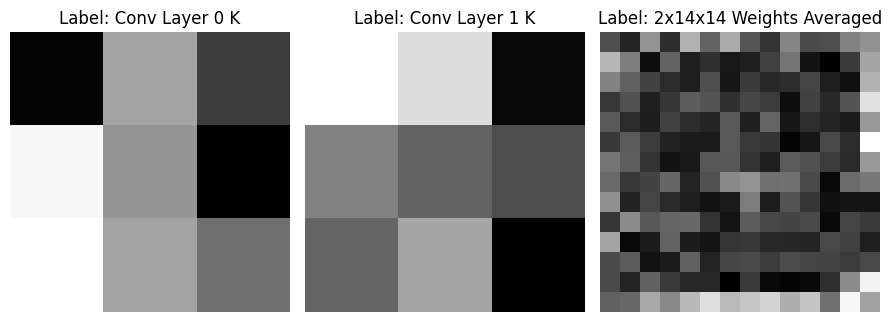

Epoch 3/20
  Train Loss: 0.2982
  Val Loss: 0.2953 | Val Acc: 91.43%


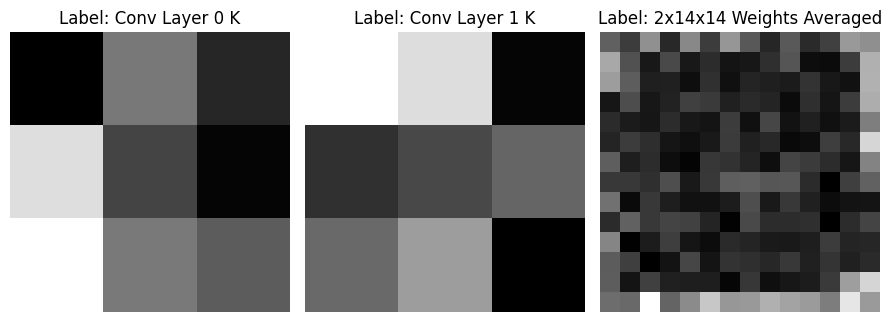

Epoch 4/20
  Train Loss: 0.2368
  Val Loss: 0.2279 | Val Acc: 93.07%


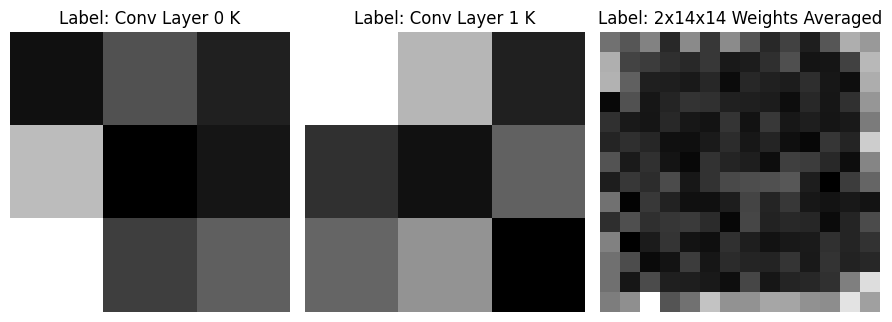

Epoch 5/20
  Train Loss: 0.1994
  Val Loss: 0.2233 | Val Acc: 93.52%


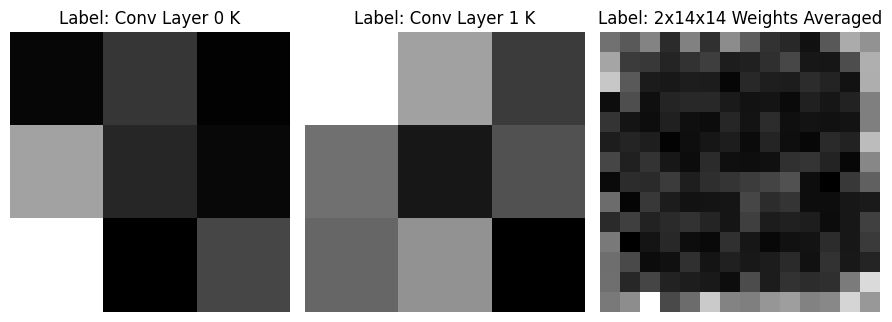

Epoch 6/20
  Train Loss: 0.1749
  Val Loss: 0.1829 | Val Acc: 94.74%


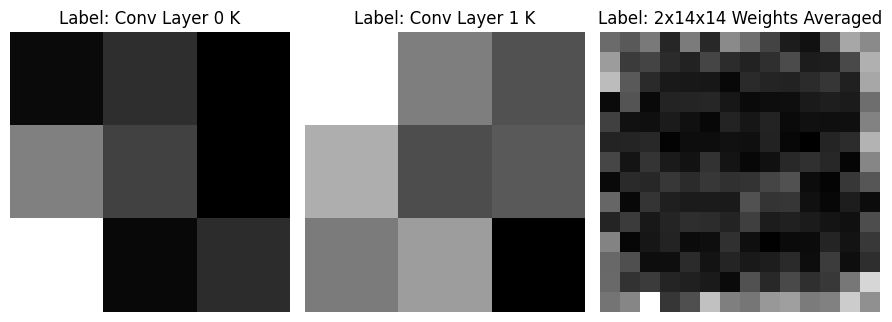

Epoch 7/20
  Train Loss: 0.1618
  Val Loss: 0.1719 | Val Acc: 94.74%


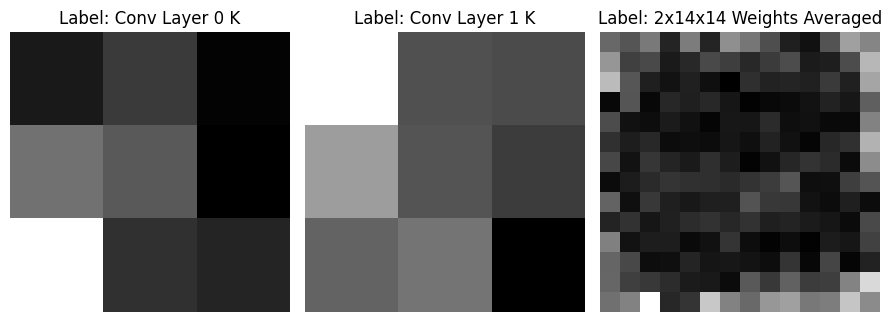

Epoch 8/20
  Train Loss: 0.1473
  Val Loss: 0.1611 | Val Acc: 95.14%


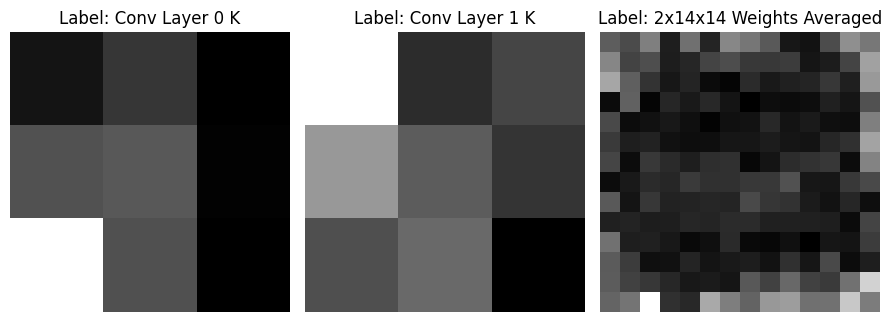

Epoch 9/20
  Train Loss: 0.1388
  Val Loss: 0.1862 | Val Acc: 94.60%


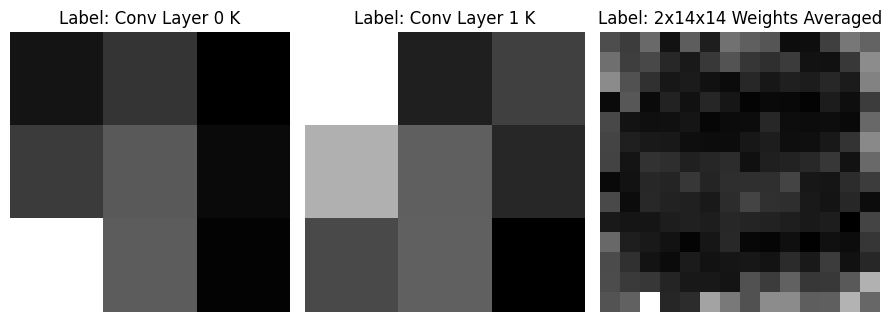

Epoch 10/20
  Train Loss: 0.1340
  Val Loss: 0.1580 | Val Acc: 95.44%


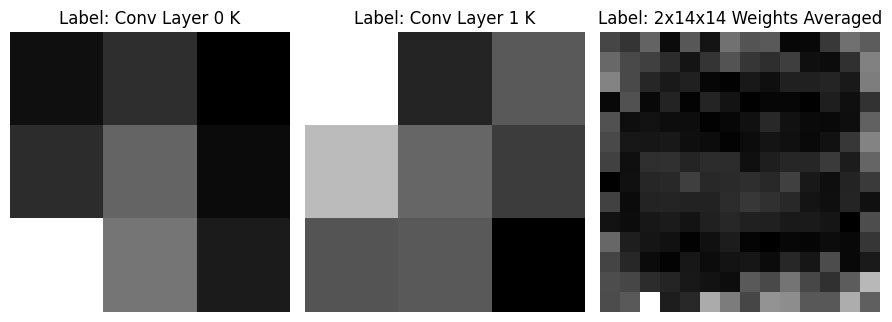

Epoch 11/20
  Train Loss: 0.1305
  Val Loss: 0.1464 | Val Acc: 95.90%


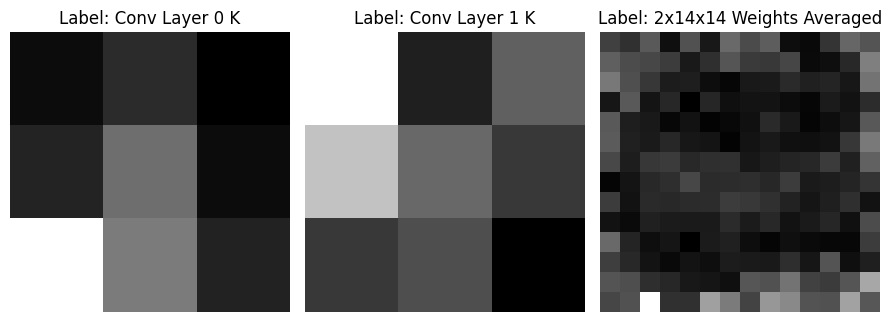

Epoch 12/20
  Train Loss: 0.1300
  Val Loss: 0.1435 | Val Acc: 95.90%


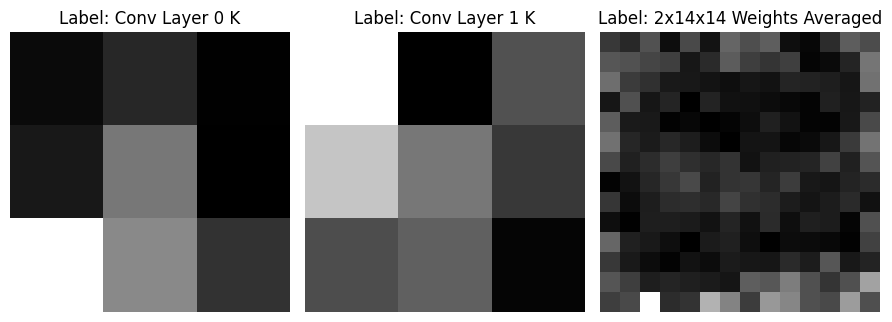

Epoch 13/20
  Train Loss: 0.1254
  Val Loss: 0.1552 | Val Acc: 95.53%


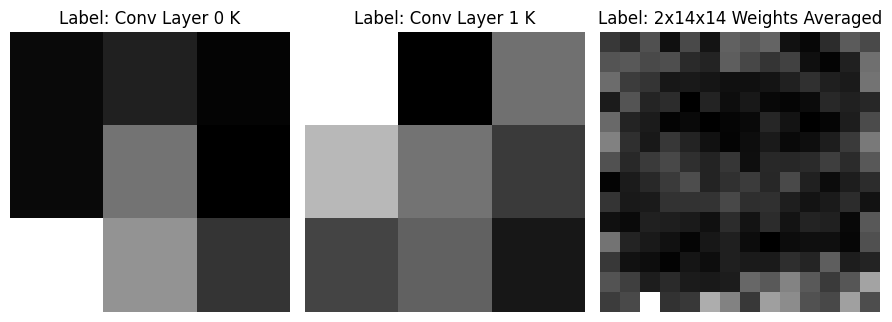

Epoch 14/20
  Train Loss: 0.1254
  Val Loss: 0.1600 | Val Acc: 95.30%


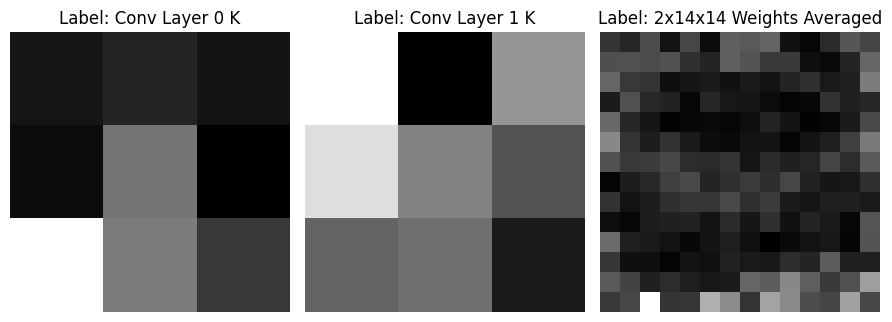

Epoch 15/20
  Train Loss: 0.1239
  Val Loss: 0.1476 | Val Acc: 95.64%


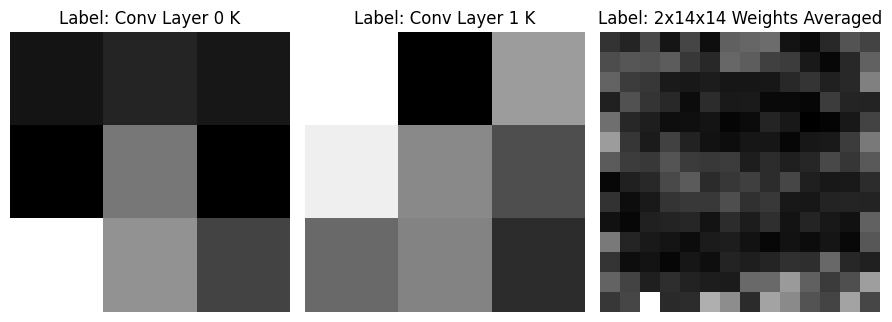

Epoch 16/20
  Train Loss: 0.1208
  Val Loss: 0.1386 | Val Acc: 96.00%


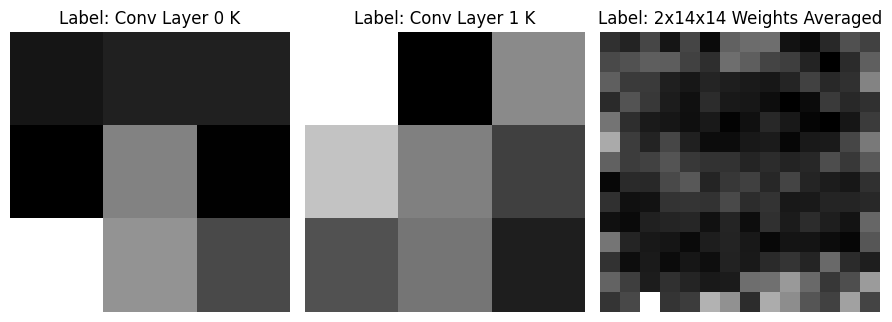

Epoch 17/20
  Train Loss: 0.1234
  Val Loss: 0.1735 | Val Acc: 95.14%


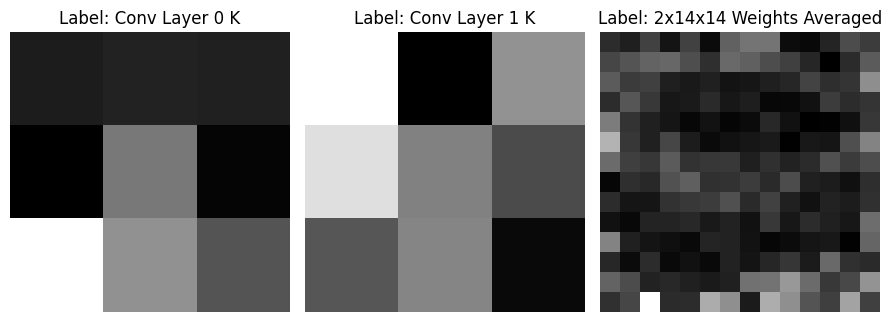

Epoch 18/20
  Train Loss: 0.1198
  Val Loss: 0.1584 | Val Acc: 95.20%


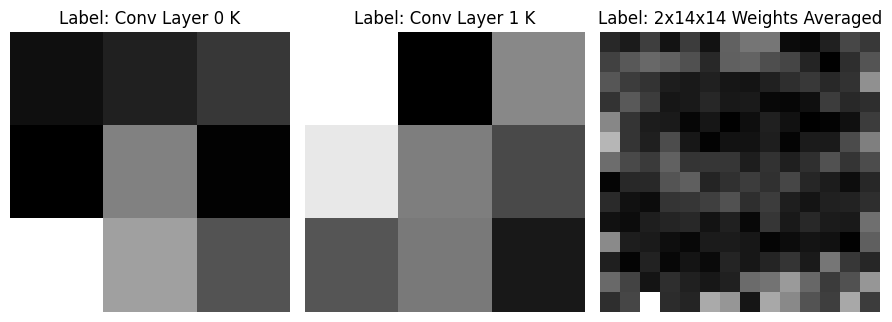

Epoch 19/20
  Train Loss: 0.1186
  Val Loss: 0.1548 | Val Acc: 95.28%


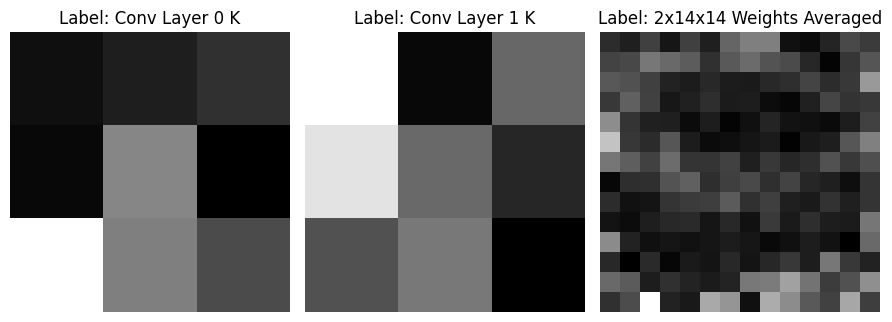

Epoch 20/20
  Train Loss: 0.1168
  Val Loss: 0.1531 | Val Acc: 95.87%


In [13]:
num_epochs = 20
best_val_loss = float('inf')
loss_factor = 0
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    # visualize weights at each layer during training
    conv_w = np.abs(model.conv1.weight[0].reshape(3, 3).detach().cpu().numpy())
    conv_w2 = np.abs(model.conv1.weight[1].reshape(3, 3).detach().cpu().numpy())
    fc1_w = np.abs(model.fc1.weight[0].reshape(2, 14, 14).detach().cpu().numpy())
    fc1_w_avg = np.mean(fc1_w, axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(conv_w, "Conv Layer 0 K", ax=axes[0])
    visualize_image(conv_w2, "Conv Layer 1 K", ax=axes[1])
    visualize_image(fc1_w_avg, "2x14x14 Weights Averaged", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, _, _ = batch
        images, labels = images.to(device).float(), labels.to(device)
        
        # forward pass
        classification_out, _, _  = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

## Evaluation

In [14]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 374.22it/s]

Final Test Accuracy: 96.04%
